## Airbnb data analysis

### Table of Contents
<ul>
<li><a href="#introduction">1. Introduction</a></li>
<li>
    <a href="#business_understanding">2. Business Understanding</a>
    <ul>
        <li><a href="#questions">2.1 Questions</a></li>
    </ul>
</li>
<li><a href="#data_understanding">3. Data Understanding</a></li>
<li><a href="#data_preperation">4. Data Preperation</a>
    <ul>
        <li><a href="#data_download">4.1 Data Download</a></li>
        <li><a href="#data_wrangling">4.2 Data Wrangling</a></li>
    </ul>
</li>
<li><a href="#qa_part1">5. Question Answering - PART I</a></li>
    <ul>
        <li><a href="#qa1">5.1 Question 1 - How has the B&B market developed lately ?</a></li>
        <li><a href="#qa2">5.2 Question 2 - How does the price change over the time ?</a></li>
    </ul>
</li>
<li><a href="#data_modeling">5. Data Modeling</a></li>
<li><a href="#qa_part2">6. Question Answering - PART II</a>
    <ul>
        <li><a href="#qa3">6.1 Question 3 - What are the key facts that affects the ratings ?</a></li>
    </ul>
</li>
</ul>

<a id='introduction'></a> 
### 1. Introduction

This notebook records the analysis process of Airbnb data, which makes part of the Udacity Data Scientist Program.

The analysis follows the <b>CRISP-DM process</b> decribed during the course:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Data Modeling
5. Result Evaluation

Notice that this notebook does not contain the final step "Deployment"

<a id='business_understanding'></a>
### 2. Business Understanding

Airbnb is an online marketplace and hospitality service that allows people to rent or lease short-term lodging accommodations, including apartments, homes, and vacation rentals. 

The concept behind Airbnb is to provide a platform where individuals can rent out their spare rooms, entire homes, or unique properties to travelers looking for a more personalized and local experience. Hosts can create listings with details about their accommodations, including photos, descriptions, and pricing. Travelers, on the other hand, can search and browse through these listings to find a suitable place to stay based on their preferences and requirements.

The whole dataset contains the information on the host property listings and their attributes such as the property type, room type, availability of amenities, calendar of listing price, customers' reviews, and more, categorized by different cities.

<a id='questions'></a>
#### 2.1 Questions

For this project, I'll explore the data from two cities: Seattle and Boston, and try to answer the following questions:

Q1. How has the B&B market developed lately ?

Q2. How does the price change over the time ?

Q3. What are the key facts that affects the ratings ?

For Q1 and Q2, I tend to answer the them based on direct data using plotting, without Data Modeling.

For Q3, we will need some data modeling.

<a id='data_understanding'></a>
### 3. Data Understanding

The [Airbnb website](http://insideairbnb.com/get-the-data/) offers the following data files for various cities:

* listings.csv: each record contains the information of a listed property, with a unique id, and a bunch of attached attributes, including:
  - those related to the property's host, such as the host's descriptions, average response time, acceptance rate, etc.
  - those related to the property itself, such as  house / room type, the location of the property, available amenities, etc.
  - those related to the clients, such as review scores rating, accuracy, cleaness, etc.
* calendar.csv: the listing price for the next 365 days for different listings (associated by listing ids).
* reviews.csv:the reviews from clients.

The dictionaries for each file can be found directly on the [Airbnb website](http://insideairbnb.com/get-the-data/).

To answer the initial 3 questions, I'll only use the <b>listing.csv</b>, and <b>calendar.csv</b> files. 

One thing to keep in mind is that since the data has been scrapted quarterly, each data file contains duplicated records for the same listed property. We need to keep it in mind when performing the data wrangling.

<a id='data_preperation'></a>
### 4. Data Preparation

This section describes the data download, aggregation, and wrangling procedure.

<a id='data_download'></a>
### 4.1 Data Download

The data download and aggregation are done using the <b>download_data.py</b> and <b>aggregate_data.py</b>. Check the [README.md](./README.md) on how to use these scrips.

<a id='data_wrangling'></a>
### 4.2 Data Wrangling

The data wrangling functions _assume_ that the "total_listings.csv" and "total_calendars.csv" are found inside `data/airbnb-boston` and `data/airbnb-seattle` directories.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_number
from matplotlib.pyplot import figure
%matplotlib inline
from datetime import datetime, timedelta

In [2]:
# some jupyter settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
# datafile paths
data_root_path = "./data"
seattle_dir_name = "airbnb-seattle"
boston_dir_name = "airbnb-boston"

seattle_data_path = os.path.join(data_root_path, seattle_dir_name)
boston_data_path = os.path.join(data_root_path, boston_dir_name)

##### 4.2.1 Data Wrangling on listing data

In [4]:
# load the data
df_listing_boston = pd.read_csv(os.path.join(boston_data_path, "total_listings.csv"))
df_listing_seattle = pd.read_csv(os.path.join(seattle_data_path, "total_listings.csv"))

df_listing_seattle["location"] = "seattle"
df_listing_boston["location"] = "boston"
df_listing_origin = pd.concat([df_listing_seattle, df_listing_boston]).reset_index(drop=True)

/tmp/ipykernel_23543/3970192522.py:2: DtypeWarning: Columns (0,2,22,41,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listing_boston = pd.read_csv(os.path.join(boston_data_path, "total_listings.csv"))
/tmp/ipykernel_23543/3970192522.py:3: DtypeWarning: Columns (2,22,41,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listing_seattle = pd.read_csv(os.path.join(seattle_data_path, "total_listings.csv"))


In [5]:
# make a copy of the original dataset
df_listing_origin_cleaned = df_listing_origin.copy()

##### a) drop duplicated ids, and convert "last_scraped" to datetime type

In [6]:
# drop duplicates in ids
#df_listing_origin_cleaned.drop_duplicates(subset=['id'], inplace=True)
# convert the datetime column
df_listing_origin_cleaned['last_scraped'] = pd.to_datetime(df_listing_origin_cleaned['last_scraped'], errors='coerce')

##### b) create the "dummy" columns for amenities

In [7]:
# check "amenities" column
df_listing_origin_cleaned["amenities"].value_counts()

amenities
["Long term stays allowed", "Hair dryer", "Bed linens", "Shampoo", "Coffee maker", "Bathtub", "Elevator", "Gym", "Heating", "Carbon monoxide alarm", "Kitchen", "Private entrance", "Hangers", "Hot water", "TV", "Paid parking on premises", "Oven", "Smoke alarm", "Self check-in", "Microwave", "Wifi", "Pets allowed", "Lockbox", "Dishwasher", "Refrigerator", "Washer \u2013\u00a0In unit", "Iron", "Dryer \u2013\u00a0In unit", "Essentials"]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      76
["Hot water", "Washer \u2013\u00a0In unit", "Gym"

we have <font color=red>12915</font> different values in "amenities" column !

In [8]:
# use the mode to impute the na value
df_listing_origin_cleaned.amenities.fillna(df_listing_origin_cleaned.amenities.mode()[0], inplace=True)
df_listing_origin_cleaned.amenities.isna().sum()

0

In [9]:
# let's find out how many "unique" amenities there are
total_amenities = np.concatenate(np.array(df_listing_origin_cleaned.amenities.str[1:-1].str.replace('"','').str.split(",")))
total_amenities = np.array([s.strip() for s in total_amenities])

amenities = np.unique(total_amenities)
counts = []
for ame in amenities:
    counts.append((total_amenities==ame).sum())

amenities_dict = pd.Series(counts, index=amenities.tolist()).sort_values(ascending=False)
amenities_dict[:5]

Smoke alarm              40471
Carbon monoxide alarm    38560
Essentials               37890
Kitchen                  37364
Wifi                     37329
dtype: int64

In [10]:
amenities_dict[50]

/tmp/ipykernel_23543/23289035.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  amenities_dict[50]


9032

So, the _51th_ item in our amenities dictionary can *only* be found in 2804 records out of the total 15329 - 15.7% of the entire sample.<br>
In order to limit the number of amenities columns (dummy), we only takes the first _50_ items, that can be found in 84.3% of the entire sample.

In [11]:
amenities_50 = amenities_dict[:50]

In [12]:
def amenities_convert (col, ame):
    return ame in col

In [13]:
amenities_cols = []
for ame in amenities_50.index:
    amenities_cols.append("amenities_"+ame)
    df_listing_origin_cleaned["amenities_"+ame]  = df_listing_origin_cleaned["amenities"].apply(amenities_convert, args=(ame,))

Let's check the dummy columns of our first sample

In [14]:
df_listing_origin_cleaned.iloc[0]["amenities"]

'["Toaster", "Iron", "Long term stays allowed", "Fire extinguisher", "Electric stove", "Dining table", "Essentials", "First aid kit", "Washer", "Bed linens", "Heating", "Keypad", "Dishes and silverware", "Clothing storage: closet", "Coffee maker", "Refrigerator", "Lock on bedroom door", "Free dryer \\u2013 In building", "Kitchen", "Wifi", "Dedicated workspace", "Mini fridge", "Microwave", "Hair dryer", "Cooking basics", "Free parking on premises", "Carbon monoxide alarm", "Smoke alarm"]'

In [15]:
print(df_listing_origin_cleaned.iloc[0]["amenities_Toaster"],
      df_listing_origin_cleaned.iloc[0]["amenities_Fire extinguisher"],
      df_listing_origin_cleaned.iloc[0]["amenities_First aid kit"],
      df_listing_origin_cleaned.iloc[0]["amenities_Carbon monoxide alarm"],
      df_listing_origin_cleaned.iloc[0]["amenities_Wifi"],
      df_listing_origin_cleaned.iloc[0]["amenities_Conditioner"],
)

True True True True True False


##### c) wrangle numeric columns
For numeric columns, I first convert the data types, then use the *mean* value to impute the missing data

In [16]:
# the numerical columns that I am interested in
features_numerical = ["host_response_time", "host_response_rate", "host_acceptance_rate",
                      "calculated_host_listings_count", "accommodates", "bathrooms",
                      "bedrooms", "beds", "price", "latitude", "longitude"]

In [17]:
df_listing_origin_cleaned.drop(columns=["bathrooms"], inplace=True)
features_numerical.remove("bathrooms")

To convert "response time" column, we need to use the customized function

In [18]:
def response_time_conv(col):
    if col == "within an hour":
        return 1
    elif col == "within a few hours":
        return 12
    elif col == "within a day":
        return 24
    elif col == "a few days or more":
        return 48
    else:
        return None

In [19]:
df_listing_origin_cleaned.host_response_time = df_listing_origin_cleaned.host_response_time.apply(response_time_conv).astype("float32")

For other columns, we simply change the format, then convert to float32

In [20]:
df_listing_origin_cleaned.host_response_rate = df_listing_origin_cleaned.host_response_rate.str.replace("%","").astype("float32")
df_listing_origin_cleaned.host_acceptance_rate = df_listing_origin_cleaned.host_acceptance_rate.str.replace("%","").astype("float32")
df_listing_origin_cleaned.price = df_listing_origin_cleaned.price.str.replace('[\$,]', '', regex=True).astype("float32")

In [21]:
# check the numeric feature statitics
df_listing_origin_cleaned[features_numerical].describe()

,host_response_time,host_response_rate,host_acceptance_rate,calculated_host_listings_count,accommodates,bedrooms,beds,price,latitude,longitude
count,36868.000000,36876.000000,38012.000000,41799.000000,41807.000000,35077.000000,41248.000000,41807.000000,41807.000000,41807.000000
mean,3.767196,97.497406,91.182579,45.337951,3.858086,1.757562,2.008025,191.776443,45.503548,-101.621934
std,6.992067,9.484589,18.586746,104.910146,14.716216,1.090059,1.507260,239.338806,2.650588,29.717751
min,1.000000,0.000000,-122.332603,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,-122.420700
25%,1.000000,100.000000,94.000000,1.000000,2.000000,1.000000,1.000000,98.000000,42.351360,-122.341125
50%,1.000000,100.000000,99.000000,3.000000,3.000000,1.000000,2.000000,148.000000,47.573073,-122.300575
75%,1.000000,100.000000,100.000000,25.000000,4.000000,2.000000,2.000000,225.000000,47.637020,-71.086640
max,48.000000,100.000000,100.000000,477.000000,1125.000000,20.000000,42.000000,10000.000000,47.748000,1125.000000


Here we see some problems: 
1. some <b>host_acceptance_rate</b> has negative values.
2. some <b>host_response_rate></b> has 0 values.
3. some <b>accommodates></b> has 0 values.
3. some <b>price</b> has 0 values.

Let's check how many records have the above problems

In [22]:
df_listing_origin_cleaned.query('host_acceptance_rate <0 or host_response_rate <0 or accommodates <= 0 or price <= 0').count()[0] / df_listing_origin_cleaned.shape[0]

/tmp/ipykernel_23543/2744776956.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_listing_origin_cleaned.query('host_acceptance_rate <0 or host_response_rate <0 or accommodates <= 0 or price <= 0').count()[0] / df_listing_origin_cleaned.shape[0]


0.0004543823986607677

These rows make up 1.7% of the entire sample. I will drop these records

In [23]:
df_listing_origin_cleaned = df_listing_origin_cleaned.query('host_acceptance_rate >=0 and host_response_rate >=0 and accommodates > 0 and price > 0')

In [24]:
# check again the numeric feature statitics
df_listing_origin_cleaned[features_numerical].describe()

,host_response_time,host_response_rate,host_acceptance_rate,calculated_host_listings_count,accommodates,bedrooms,beds,price,latitude,longitude
count,36562.000000,36562.000000,36562.000000,36562.000000,36562.000000,30588.000000,36059.000000,36562.000000,36562.000000,36562.000000
mean,3.648734,97.645264,91.749985,51.190307,3.695914,1.761933,2.017139,190.927322,45.535067,-102.062695
std,6.757320,8.806526,17.318512,110.888556,2.458658,1.094818,1.485088,207.955292,2.584200,25.060284
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,10.000000,42.231170,-122.420700
25%,1.000000,100.000000,94.000000,1.000000,2.000000,1.000000,1.000000,99.000000,42.351731,-122.341169
50%,1.000000,100.000000,99.000000,4.000000,3.000000,1.000000,2.000000,150.000000,47.575820,-122.301559
75%,1.000000,100.000000,100.000000,32.000000,4.000000,2.000000,2.000000,229.000000,47.636600,-71.085090
max,48.000000,100.000000,100.000000,477.000000,16.000000,16.000000,22.000000,10000.000000,47.748000,-70.913250


Convert all the numeric columns to float32, and use the mean value to impute the missing values

In [25]:
for feature in features_numerical:
    df_listing_origin_cleaned[feature] = df_listing_origin_cleaned[feature].astype('float32')
    df_listing_origin_cleaned[feature].fillna(df_listing_origin_cleaned[feature].mean(), inplace=True)

In [26]:
df_listing_origin_cleaned[features_numerical].isna().sum()

host_response_time                0
host_response_rate                0
host_acceptance_rate              0
calculated_host_listings_count    0
accommodates                      0
bedrooms                          0
beds                              0
price                             0
latitude                          0
longitude                         0
dtype: int64

##### d) wrangle categorical columns
For categorical columns, I use the *mode* value to impute the missing data

In [27]:
features_categorical = ["host_is_superhost", "host_identity_verified", "property_type", "room_type"] # amenities has been processed seperately

In [28]:
for feature in features_categorical:
    df_listing_origin_cleaned[feature].fillna(df_listing_origin_cleaned[feature].mode()[0], inplace=True)

In [29]:
df_listing_origin_cleaned[features_categorical].isna().sum()

host_is_superhost         0
host_identity_verified    0
property_type             0
room_type                 0
dtype: int64

In [30]:
# before use pd.get_dummies to get dummy variables, let's have a check on "property_type" and "room_type" columns
df_listing_origin_cleaned.room_type.value_counts()

room_type
Entire home/apt    28529
Private room        7882
Hotel room            76
Shared room           75
Name: count, dtype: int64

In [31]:
df_listing_origin_cleaned.property_type.value_counts()

property_type
Entire rental unit                    12267
Entire home                            5612
Private room in home                   3271
Entire condo                           3187
Private room in rental unit            2623
Entire guest suite                     2481
Entire townhouse                       1912
Entire serviced apartment              1310
Entire guesthouse                       929
Private room in townhouse               525
Room in boutique hotel                  416
Private room in condo                   303
Private room in bed and breakfast       280
Entire loft                             256
Entire cottage                          155
Private room in guest suite             150
Room in hotel                           136
Entire bungalow                          98
Entire vacation home                     70
Tiny home                                67
Private room in serviced apartment       64
Private room in bungalow                 51
Boat              

In [32]:
df_categorical_dummies = pd.get_dummies(df_listing_origin_cleaned[features_categorical], drop_first=True)
features_categorical_dummy = df_categorical_dummies.columns.tolist()

In [33]:
df_listing_origin_cleaned.drop(columns=["amenities"], inplace=True)
df_listing_origin_cleaned.drop(columns=features_categorical, inplace=True)

In [34]:
df_listing_origin_cleaned = pd.concat([df_listing_origin_cleaned,
                                       df_categorical_dummies], axis=1)

##### 4.2.2 Data Wrangling on calendar data

In [35]:
df_calendar_boston = pd.read_csv(os.path.join(boston_data_path, "total_calendars.csv"))
df_calendar_seattle = pd.read_csv(os.path.join(seattle_data_path, "total_calendars.csv"))

df_calendar_seattle["location"] = "seattle"
df_calendar_boston["location"] = "boston"

for calendar data, we simply need to convert the price column and remove the NaN values.

Besides, we need to remove the records where price <=0

In [36]:
df_calendar_seattle['price'] = df_calendar_seattle['price'].str.replace('[\$,]', '', regex=True).astype(float)
df_calendar_seattle.dropna(subset=["price"], inplace=True)
df_calendar_seattle = df_calendar_seattle.query('price > 0')

df_calendar_boston['price'] = df_calendar_boston['price'].str.replace('[\$,]', '', regex=True).astype(float)
df_calendar_boston.dropna(subset=["price"], inplace=True)
df_calendar_boston = df_calendar_boston.query('price > 0')

<a id='qa_part1'></a>
### 5. Question Answering - PART I

<a id='qa1'></a>
#### 5.1 Question 1 - How has the B&B market developed lately ?

In order to figure out the development of the renting market, I am about to use the following 2 indicators:
1. the number of the newly registered properties during the year.
2. the newly added amount of reviews during the year.

These 2 indicators will help us get an idea on the overall B&B market trend.

The listing dataset was scrapped periodically from the internet, the timestamps are indicated by column "last_scraped". Let's take a look at the timestamps

In [37]:
df_listing_origin_cleaned.last_scraped.value_counts()

last_scraped
2023-03-25    5615
2022-12-24    5366
2022-09-18    5274
2022-09-15    4528
2023-06-22    3335
2022-12-21    3151
2023-06-24    3096
2023-06-25    2748
2023-03-19    2726
2023-03-20     605
2023-06-21     115
2022-09-22       1
2023-06-30       1
2022-10-02       1
Name: count, dtype: int64

It looks like that the timestamps fall in quarterly month: <b>2022-09, 2022-12, 2023-03, 2023-06</b>
Let's calculate the number of listings based on these durations

In [38]:
categories = ["before 2022-09", "2022-09 ~ 2022-12", "2022-12 ~ 2023-03", "2023-03 ~ 2023-06"]
time_stamps = ["2022-09-30", "2022-12-30", "2023-03-30", "2023-06-30"]

In [39]:
listing_cnt = [[df_listing_origin_cleaned.query('location == "seattle" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id']).count()[0] for ts in time_stamps],
               [df_listing_origin_cleaned.query('location == "boston" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id']).count()[0] for ts in time_stamps]]

/tmp/ipykernel_23543/1569396462.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  listing_cnt = [[df_listing_origin_cleaned.query('location == "seattle" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id']).count()[0] for ts in time_stamps],
/tmp/ipykernel_23543/1569396462.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  listing_cnt = [[df_listing_origin_cleaned.query('location == "seattle" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id']).count()[0] for ts in time_stamps],
/tmp/ipykernel_23543/1569396462.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprec

In [40]:
listing_cnt

[[5275, 6296, 6899, 7727], [4528, 5122, 5672, 6372]]

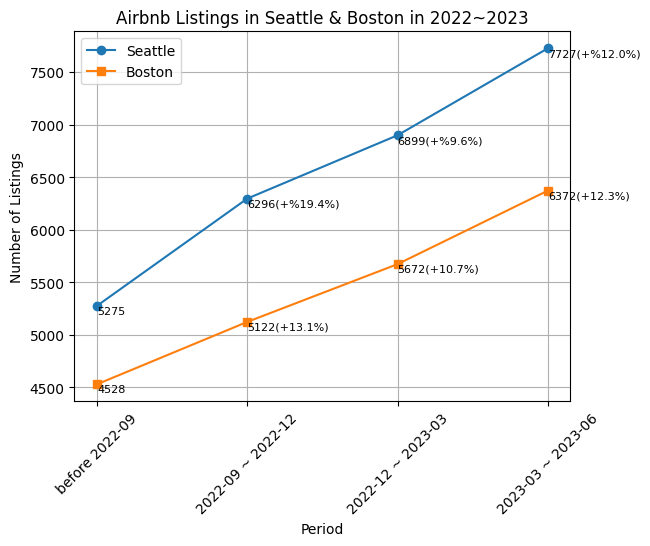

In [41]:
# plot 

plt.plot(categories, listing_cnt[0], marker='o', label="Seattle")
plt.plot(categories, listing_cnt[1], marker='s', label="Boston")

last_count = 0
ax = plt.gca()
for i, j in zip(categories, listing_cnt[0]):
    if last_count == 0:
        ax.text(i, j, f'{j}', ha='left', va='top', fontsize=8)
        last_count = j
    else:
        text = f'{j}' + '(+%{:.1f}%)'.format((j-last_count)/last_count*100) 
        ax.text(i, j, text, ha='left', va='top', fontsize=8)
        last_count = j

last_count = 0
for i, j in zip(categories, listing_cnt[1]):
    if last_count == 0:
        ax.text(i, j, f'{j}', ha='left', va='top', fontsize=8)
        last_count = j
    else:
        text = f'{j}' + '(+{:.1f}%)'.format((j-last_count)/last_count*100) 
        ax.text(i, j, text, ha='left', va='top', fontsize=8)
        last_count = j

plt.title("Airbnb Listings in Seattle & Boston in 2022~2023")
plt.ylabel("Number of Listings")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

How, calculate the number of reviews

In [42]:
review_cnt = [[df_listing_origin_cleaned.query('location == "seattle" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id'], keep='last').number_of_reviews.sum() for ts in time_stamps],
              [df_listing_origin_cleaned.query('location == "boston" and last_scraped < "{}"'.format(ts)).drop_duplicates(subset=['id'], keep='last').number_of_reviews.sum() for ts in time_stamps]]

In [43]:
review_cnt

[[341802.0, 382599.0, 409483.0, 449847.0],
 [228039.0, 247367.0, 256559.0, 277856.0]]

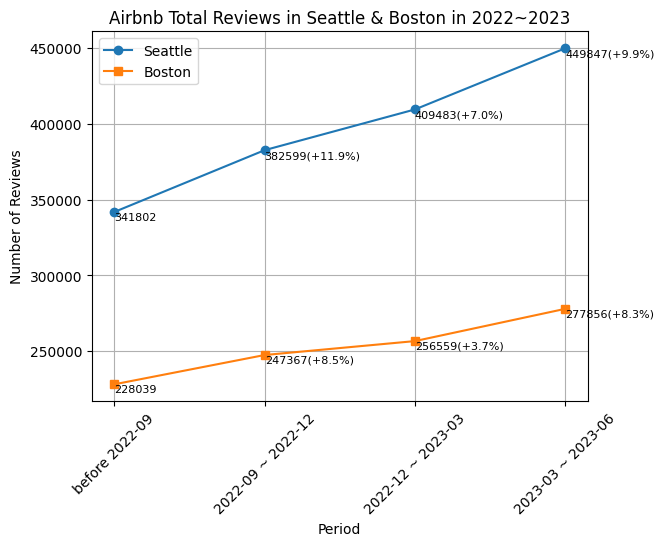

In [44]:
# plot 

plt.plot(categories, review_cnt[0], marker='o', label="Seattle")
plt.plot(categories, review_cnt[1], marker='s', label="Boston")

ax = plt.gca()

last_count = 0
for i, j in zip(categories, review_cnt[0]):
    if last_count == 0:
        ax.text(i, j, f'{int(j)}', ha='left', va='top', fontsize=8)
        last_count = j
    else:
        text = f'{int(j)}' + '(+{:.1f}%)'.format((j-last_count)/last_count*100) 
        ax.text(i, j, text, ha='left', va='top', fontsize=8)
        last_count = j

last_count = 0
for i, j in zip(categories, review_cnt[1]):
    if last_count == 0:
        ax.text(i, j, f'{int(j)}', ha='left', va='top', fontsize=8)
        last_count = j
    else:
        text = f'{int(j)}' + '(+{:.1f}%)'.format((j-last_count)/last_count*100) 
        ax.text(i, j, text, ha='left', va='top', fontsize=8)
        last_count = j        

plt.title("Airbnb Total Reviews in Seattle & Boston in 2022~2023")
plt.ylabel("Number of Reviews")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

Well, the above 2 plot show that:
1. The quaterly increase of B&B listing is double digit in both cities, over the last 3 quarters. In particular, during 2022-09 ~ 2022-12, the increase has been 19.4% in Seattle and 13.1% in Boston.
2. The quaterly increase of total reviews was 11.9%, 7.0% and 9.9% in Seattle during the last 3 quarters, and 8.5%, 3.7% and 8.3% in Boston during the last 3 quarters.

##### Answer to Question 1:

The B&B market has shown significant boost during the last year, both in Seattle, and Boston, in terms of newly registered properties, and the number overall customers' reviews. Market increase in Seattle has shown more powerful trend than in Boston. The data also reflects the strong recovery of the tourists market in the U.S.

<a id='qa2'></a>
#### 5.2 Question 2 - How does the price change over the time ?

To unswer this question, I'll use the calendar data cleaned in the previous section.

First, let's check the price distributions in Seattle and Boston

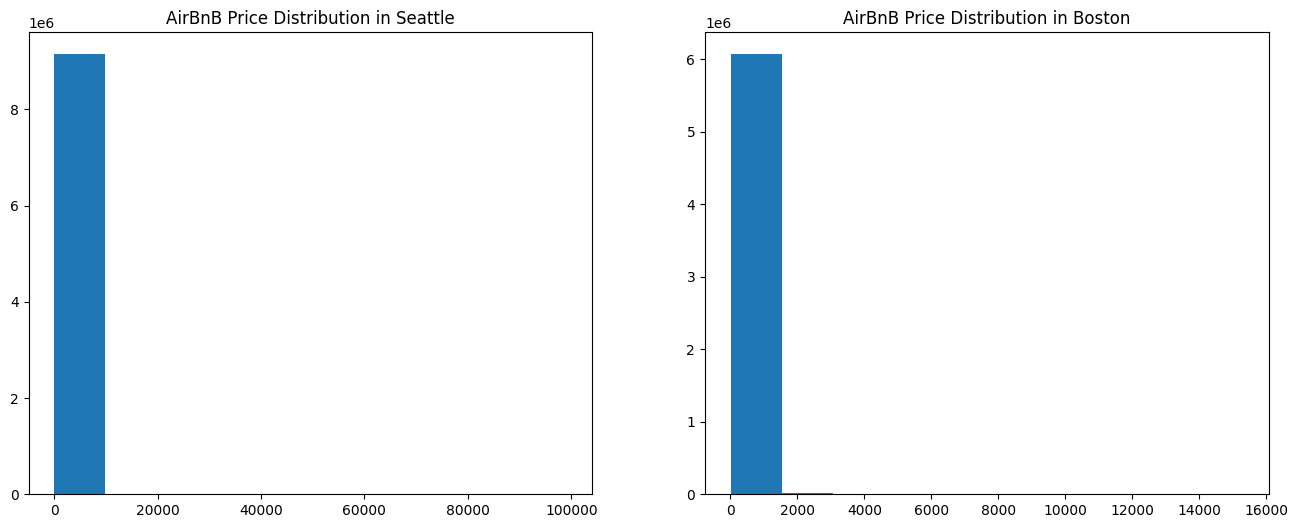

In [45]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(df_calendar_seattle["price"]);
plt.title("AirBnB Price Distribution in Seattle");

plt.subplot(1, 2, 2)
plt.hist(df_calendar_boston["price"]);
plt.title("AirBnB Price Distribution in Boston");


The price distribution in both cities show extreme skewness. Let's change to log scale and see again:

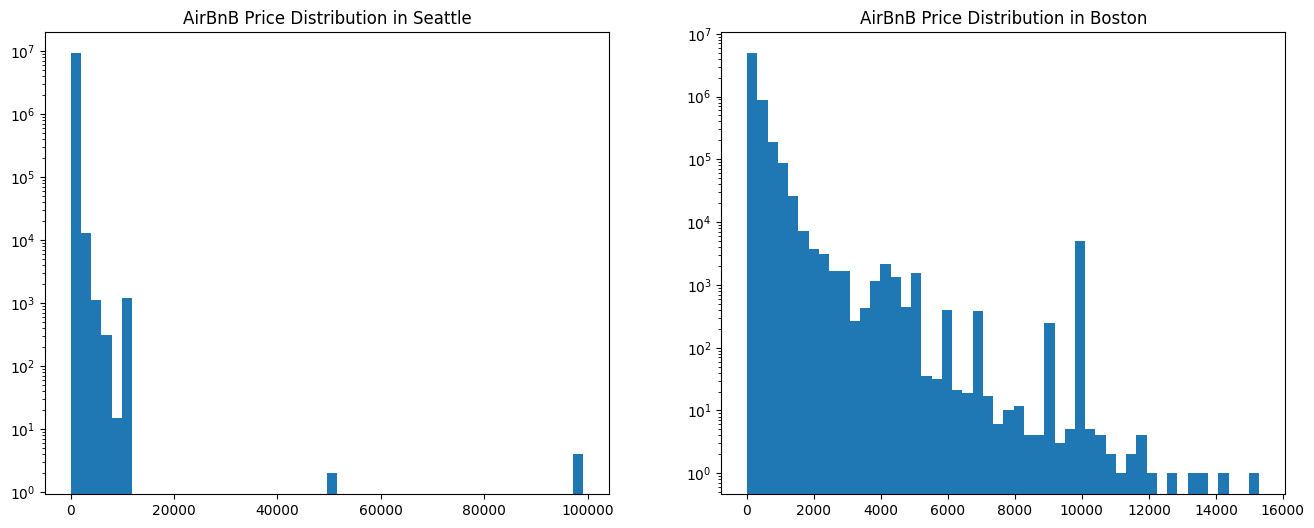

In [46]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.hist(df_calendar_seattle["price"], bins=50, log=True);
plt.title("AirBnB Price Distribution in Seattle");

plt.subplot(1, 2, 2)
plt.hist(df_calendar_boston["price"], bins=50, log=True);
plt.title("AirBnB Price Distribution in Boston");

Using log scale, we see that the price distribution show different patterns in 2 cities. In order to compare the price between 2 cities, we need a unified criteria. In this project, we use a cut-off price of <b>3000$</b>.

In [47]:
df_calendar_seattle_under_3k_usd = df_calendar_seattle.query('price < 3000 and price > 0')
df_calendar_boston_under_3k_usd = df_calendar_boston.query('price < 3000 and price > 0')

In order to suppress the noise in data, I calculate the average price within each week and plot the data in a week-based timeline.

In [48]:
# take 2022-09-19 to 2024-06-16 as the time span
start_date = datetime.strptime("2022-09-19", "%Y-%m-%d") # monday
end_date = datetime.strptime("2024-06-16", "%Y-%m-%d") # sunday

dates_array = []

while start_date <= end_date:
    dates_array.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=7)

print(dates_array)

['2022-09-19', '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03', '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01', '2023-05-08', '2023-05-15', '2023-05-22', '2023-05-29', '2023-06-05', '2023-06-12', '2023-06-19', '2023-06-26', '2023-07-03', '2023-07-10', '2023-07-17', '2023-07-24', '2023-07-31', '2023-08-07', '2023-08-14', '2023-08-21', '2023-08-28', '2023-09-04', '2023-09-11', '2023-09-18', '2023-09-25', '2023-10-02', '2023-10-09', '2023-10-16', '2023-10-23', '2023-10-30', '2023-11-06', '2023-11-13', '2023-11-20', '2023-11-27', '2023-12-04', '2023-12-11', '2023-12-18', '2023-12-25', '2024-01-01', '2024-01-08', '2024-01-15', '2024-01-22', '2024

In [49]:
# calculate the weekly average price. This cell takes a while to execute
avg_price_seattle_arr = []
std_price_seattle_arr = []
avg_price_boston_arr = []
std_price_boston_arr = []
startdate = dates_array[0]
for date in dates_array[1:]:
    subset = df_calendar_seattle.query('date >= "{}" and date < "{}"'.format(startdate, date))
    avg_price_seattle_arr.append(subset["price"].mean())
    std_price_seattle_arr.append(subset["price"].std())
    
    subset = df_calendar_boston.query('date >= "{}" and date < "{}"'.format(startdate, date))
    avg_price_boston_arr.append(subset["price"].mean())
    std_price_boston_arr.append(subset["price"].std())

    startdate = date

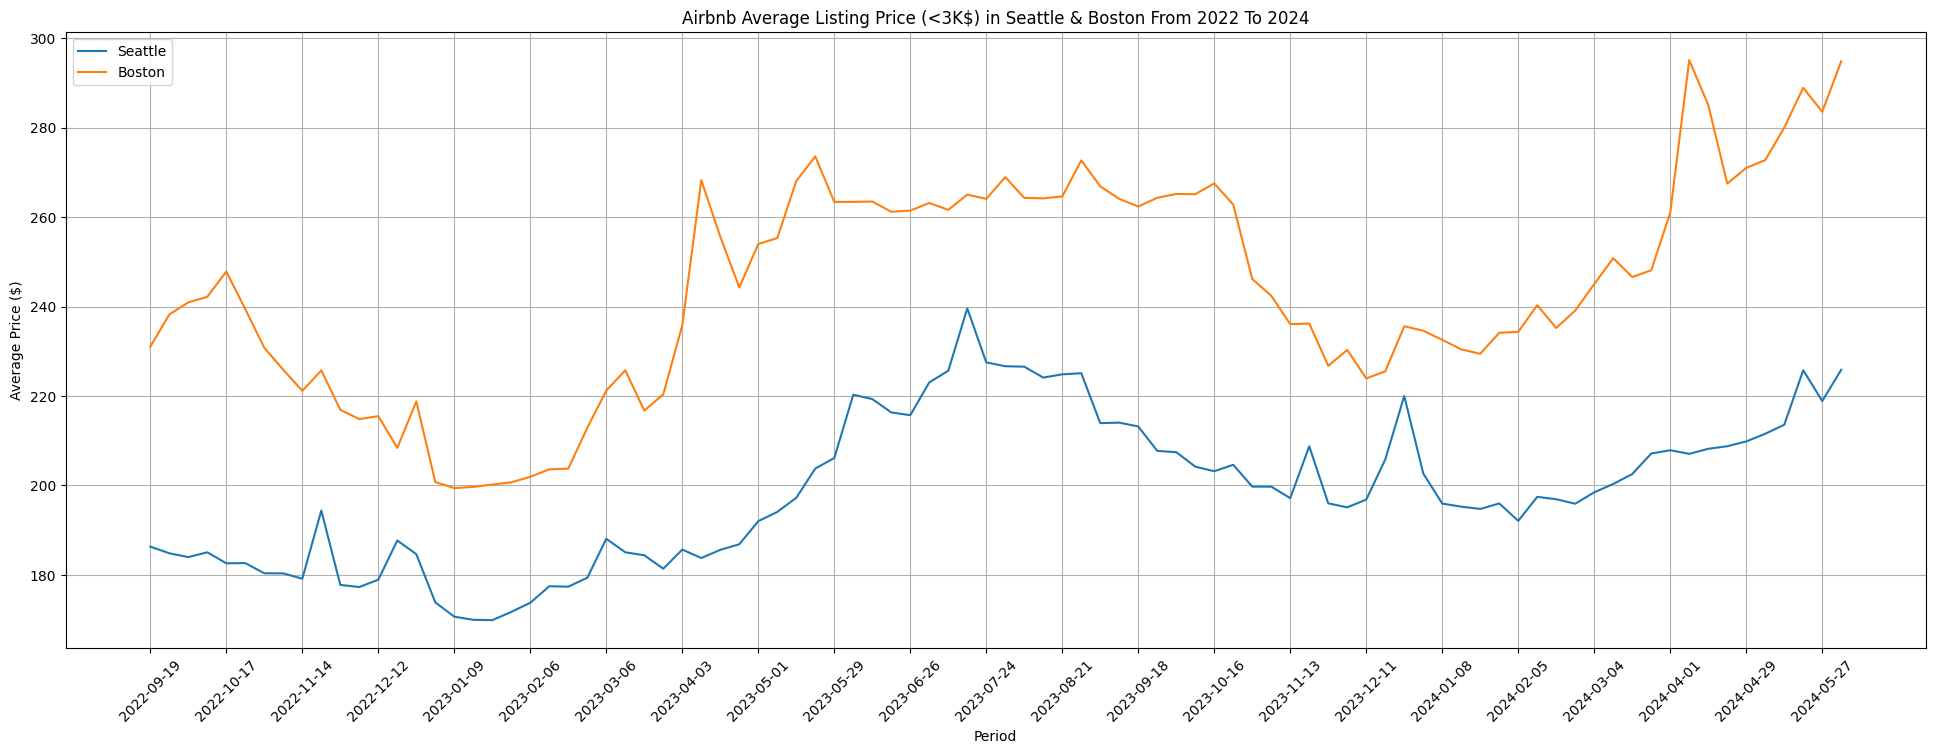

In [50]:
# plot the data
fig = plt.figure(figsize=(24, 8))
plt.plot(dates_array[:-1], avg_price_seattle_arr, label="Seattle")
plt.plot(dates_array[:-1], avg_price_boston_arr, label="Boston")

plt.xticks(dates_array[::4])

plt.title("Airbnb Average Listing Price (<3K$) in Seattle & Boston From 2022 To 2024")
plt.ylabel("Average Price ($)")
plt.xlabel("Period")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

Yes we do see a pattern of "cycle" here. For properties with listing price < 3000$, the average price is lower during the cold seaon of winter and spring (December to March), and higher during the hot season of summer and autumn (Jun to October). In Boston, there is a roughly 20% average price increasing during the hot season, and a max of 40%+ increasing is observed in Seattle. 

Another interesting thing is that although the average price in both cities still follow this "cycle" patten, the overall average prices in both cities showed an upward trend compared to the same period in 2023. This shows that hosts in Airbnb generally have increased confidence in the market for the coming year.

Here I raise another question: what does the pattern of the average daily price look like during a week?

Let's find out!

In [51]:
# take 30 days as the time span
start_date = datetime.strptime("2022-09-19", "%Y-%m-%d") # monday
end_date = datetime.strptime("2022-10-19", "%Y-%m-%d") # sunday

dates_array = []

while start_date <= end_date:
    dates_array.append(start_date.strftime("%Y-%m-%d"))
    start_date += timedelta(days=1)

print(dates_array)

['2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03', '2022-10-04', '2022-10-05', '2022-10-06', '2022-10-07', '2022-10-08', '2022-10-09', '2022-10-10', '2022-10-11', '2022-10-12', '2022-10-13', '2022-10-14', '2022-10-15', '2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19']


In [52]:
# calculate the daily average price.
avg_price_seattle_arr = []
std_price_seattle_arr = []
avg_price_boston_arr = []
std_price_boston_arr = []
for date in dates_array:
    subset = df_calendar_seattle.query('date == "{}"'.format(date))
    avg_price_seattle_arr.append(subset["price"].mean())
    std_price_seattle_arr.append(subset["price"].std())
    
    subset = df_calendar_boston.query('date == "{}"'.format(date))
    avg_price_boston_arr.append(subset["price"].mean())
    std_price_boston_arr.append(subset["price"].std())

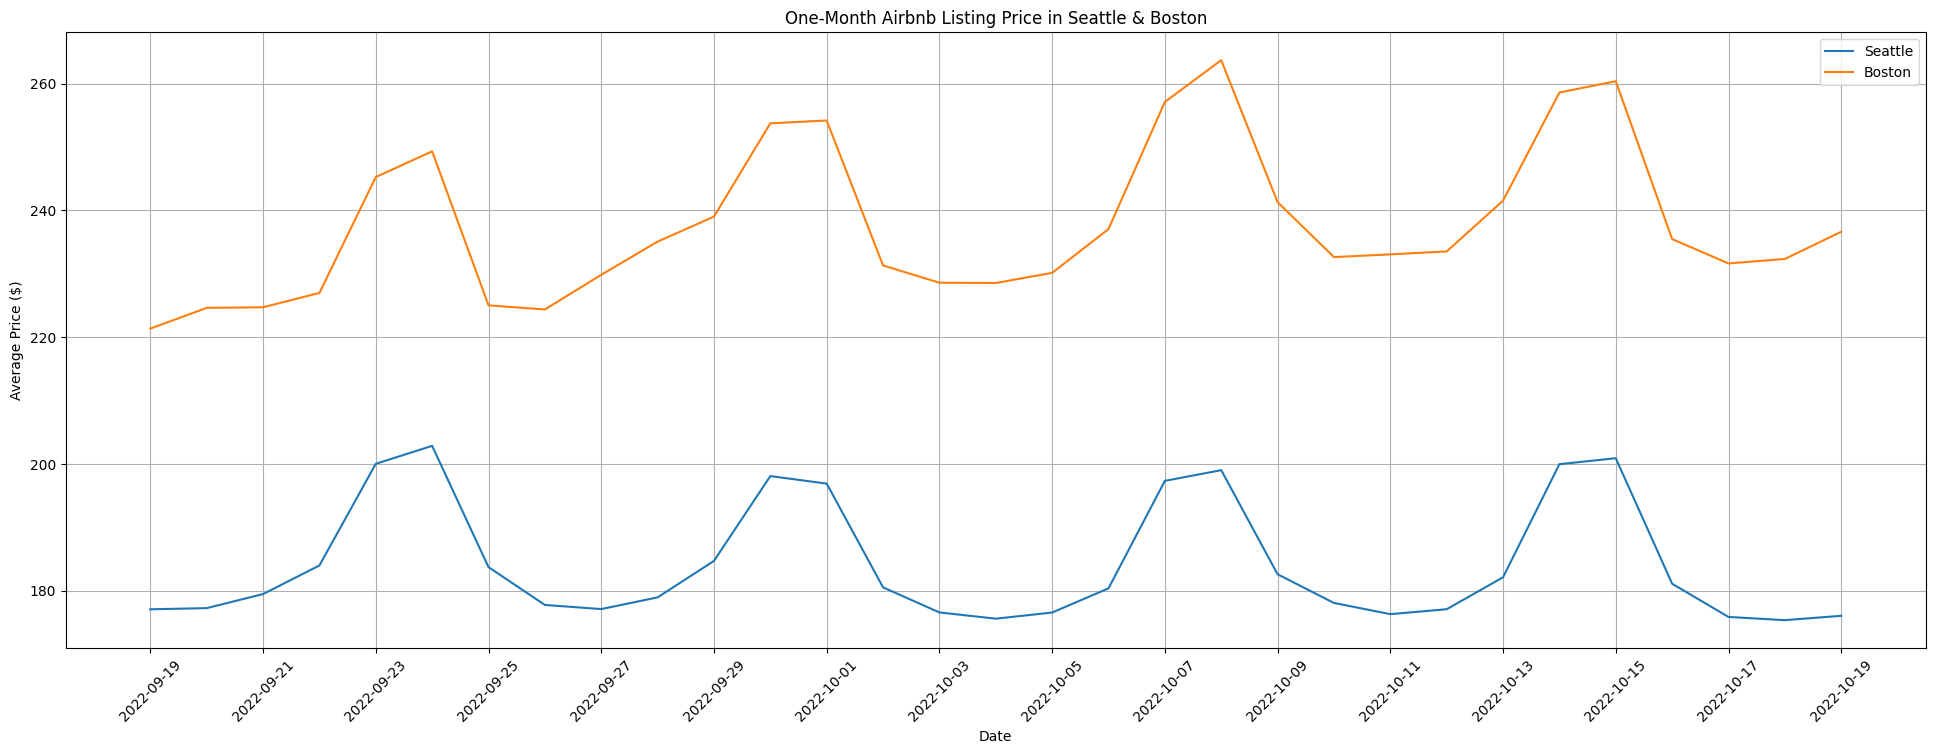

In [53]:
# plot the data
fig = plt.figure(figsize=(24, 8))
plt.plot(dates_array, avg_price_seattle_arr, label="Seattle")
plt.plot(dates_array, avg_price_boston_arr, label="Boston")

plt.xticks(dates_array[::2])

plt.title("One-Month Airbnb Listing Price in Seattle & Boston")
plt.ylabel("Average Price ($)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

Yes! The daily average price also follows a "cycle" pattern. The price is generally lower during the weekdays, and higher during the weekends (Friday & Saturday). It does make sense.

##### Answer to Question 2:

The Airbnb average listing price has a "cycle" pattern that is higher during the summer and autumn while lower during the winter and spring. Compared to Boston, this price difference is more pronounced in Seattle.

The overall average prices in both cities showed an upward trend compared to the same period in 2023. This shows that hosts in Airbnb generally have increased confidence in the market for the coming year.

<a id='data_modeling'></a> 
### 5. Data Modeling

To answer the 3rd question, I need to do some data modeling. 

I plan to use the data to fit a regression model. The regression will use several listing features as independent variables, and "review_scores_rating" as dependent variable.

During the data wrangling process, I have already tidied up some features. They are:
1. Numeric features: "host_response_time", "host_response_rate", "host_acceptance_rate", "calculated_host_listings_count", "accommodates", "bathrooms", "bedrooms", "beds", "price", "latitude", "longitude".
2. Categorical features: "host_is_superhost", "host_identity_verified", "property_type", "room_type"
3. Amenities features

I have wrangled the numeric features, and converted categorical and amenities features to dummy variables. 

For the choice of model, I choose the RidgeCV from sklearn. The main reason behind is that I have quite a few independent variables, and I do not know if the problems of multi-collinearity exist among these features. Besides, the some dummy_variables contains items which occurs only once or twice in the entire dataset. These make me decide to use a linear model with regularization and cross-validation.

In [54]:
# 1st: remove the duplicated ids.
df_listing_origin_cleaned_qa3 = df_listing_origin_cleaned.drop_duplicates(subset=['id'], keep='last')

In [57]:
# 2nd: remove the records with 0 number_of_reviews
df_listing_origin_cleaned_qa3 = df_listing_origin_cleaned_qa3.query('number_of_reviews > 0')

In [56]:
#df_listing_origin_cleaned_qa3.dropna(inplace=True)

In [59]:
# get independent feature columns
independent_features = features_numerical + features_categorical_dummy + amenities_cols
df_listing_origin_cleaned_qa3.dropna(subset=independent_features, inplace=True)

In [62]:
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [61]:
X = df_listing_origin_cleaned_qa3[independent_features]
y = df_listing_origin_cleaned_qa3["review_scores_rating"]

In [63]:
# we need to standardize each independent variable
model = make_pipeline(StandardScaler(), RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2'))

In [64]:
results = model.fit(X, y)
print("r2 score:{:.3f}".format(results.score(X,y)))

r2 score:0.150


Hmmmm, we have a problem here: The r2 score is very low (<0.3), which means that the dependent variable (review_scores_rating) can not be adequately explained by all those independent variables.

The first thing I checked is the distribution of our dependent variable: review_scores_rating

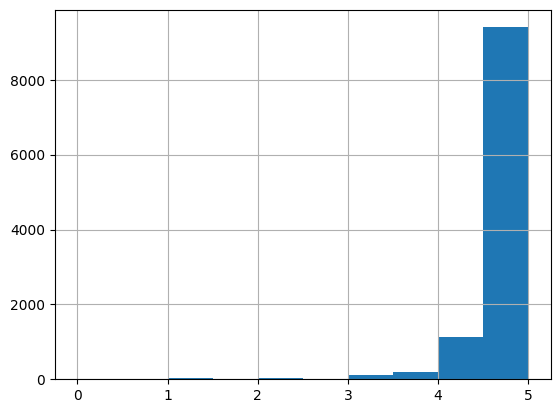

In [72]:
df_listing_origin_cleaned_qa3.review_scores_rating.hist();

We can see that the distribution is indeed very skewed. This makes me wondering the distribution of another feature: number_of_reviews

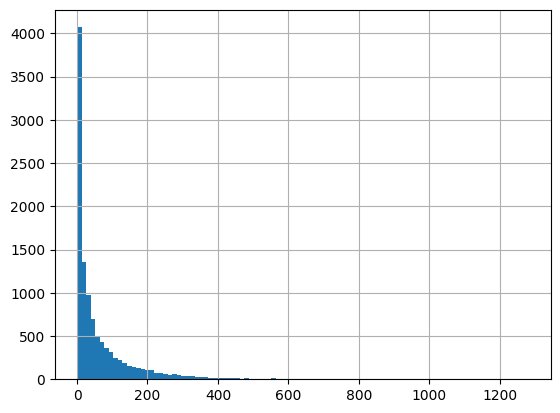

In [75]:
df_listing_origin_cleaned_qa3.number_of_reviews.hist(bins=100);

Most of the listings have very few reviews (1 or 2). This tiny sample size might potentially lead to very biased conclusion.

So, in order to increse the "credibility" of the dependent variable review_scores_rating, I decided to use the listing data with at least 5 reviews.

In [76]:
df_listing_origin_cleaned_qa3 = df_listing_origin_cleaned_qa3.query('number_of_reviews > 5')

In [77]:
X = df_listing_origin_cleaned_qa3[independent_features]
y = df_listing_origin_cleaned_qa3["review_scores_rating"]

In [79]:
results = model.fit(X, y)
print("r2 score:{:.3f}".format(results.score(X,y)))

r2 score:0.376


It does make a huge difference! 

By filtering on "number_of_reviews" to use sample with > 5 reviews, the r2 score increased from 0.15 to 0.376, which is an accepted r2 value. (although still not substaintial)

Let's plot the normalized coefficients of the independent variables.

Text(0.5, 1.0, 'Normalized Coefficients By RidgeCV model')

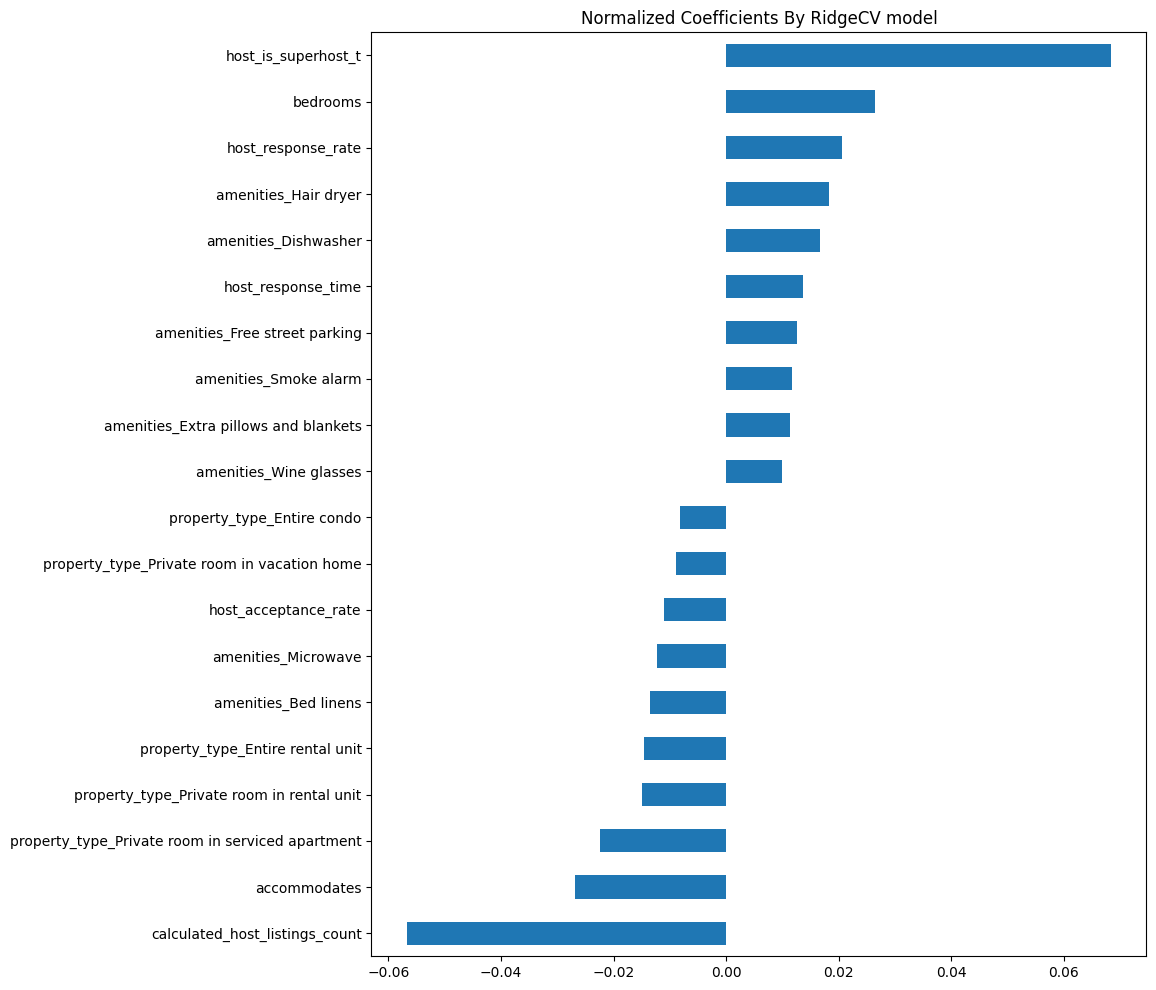

In [80]:
coef = model["ridgecv"].coef_
coef = pd.Series(coef, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
fig = plt.figure(figsize=(10, 12))

imp_coef.plot(kind = "barh")
plt.title("Normalized Coefficients By RidgeCV model");

<a id='qa_part2'></a>
### 6. Question Answering - PART II

<a id='qa3'></a>
#### 6.1 Question 3 - What are the key facts that affects the ratings ?

After data modeling, I am ready to answer the 3rd question.

As can be seen from the plot above "Normalized Coefficients By RidgeCV model", the following facts have reasonable positive impact to the rating:
1. The host is a superhost
2. Number of bedrooms
3. The host response rate and time
4. Amenities like Hair dryer, Dishwasher, Free street parking.

Among these facts, whether the host is a superhost or not has substaintially larger positive impact respect to others. So the identity of superhost is a real "facade" to boost your rating in Airbnb.

On the other hand, the following facts have reasonable negative impact to the rating:
1. The number of listings under the same host
2. The number of accommodates
3. Whether the property is a private room in serviced apartment or rental unit.

I would guess that if a host have many listed properties, he/she might not give enough attention to each one of them, and thus degradating the user experience and result in a lower rating.

Other than that, the higher number of accommodates might also affect the user experience.